In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
#Decision tree classifier for binarey classification
#Categorical variables use dictionary vectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
import mlflow
import pickle

In [82]:
import logging

# Basic configuration (do this once at the start of your script)
logging.basicConfig(
    level=logging.INFO,  # Minimum level to display
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('app.log'),  # Log to file
        logging.StreamHandler()  # Log to console
    ]
)
logger = logging.getLogger(__name__)  # Create a logger for your module

In [83]:
#Load Dataset

url = "https://raw.githubusercontent.com/wisabd/MLOps-Hands-on/main/CreditScoring.csv"
Data = pd.read_csv(url)

# Log basic data info
logger.info("Data shape: %s", Data.shape)
logger.debug("Data columns: %s", Data.columns.tolist())
Data.head()

2025-06-18 17:06:33,823 - __main__ - INFO - Data shape: (4455, 14)


,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [84]:
logger.info("Descriptive statistics:\n%s", Data.describe().to_string())
def log_data_sample(df, n=3):
    """Log a sample of the dataframe"""
    logger.info("Data sample (first %d rows):\n%s", n, df.head(n).to_string())
log_data_sample(Data, 5)

2025-06-18 17:06:33,877 - __main__ - INFO - Descriptive statistics:
            Status    Seniority         Home         Time          Age      Marital      Records          Job     Expenses        Income        Assets          Debt       Amount         Price
count  4455.000000  4455.000000  4455.000000  4455.000000  4455.000000  4455.000000  4455.000000  4455.000000  4455.000000  4.455000e+03  4.455000e+03  4.455000e+03  4455.000000   4455.000000
mean      1.281257     7.987205     2.657015    46.441751    37.077666     1.879012     1.173513     1.675870    55.568799  7.633170e+05  1.060341e+06  4.043820e+05  1039.021773   1462.875645
std       0.450162     8.173444     1.610467    14.655225    10.984856     0.643748     0.378733     0.954035    19.515878  8.703625e+06  1.021757e+07  6.344253e+06   474.543007    628.089913
min       0.000000     0.000000     0.000000     6.000000    18.000000     0.000000     1.000000     0.000000    35.000000  0.000000e+00  0.000000e+00  0.000000e+00

Home
2     47.3%
1    21.84%
5    17.58%
6     7.16%
3     5.54%
4     0.45%
0     0.13%
Name: proportion, dtype: object


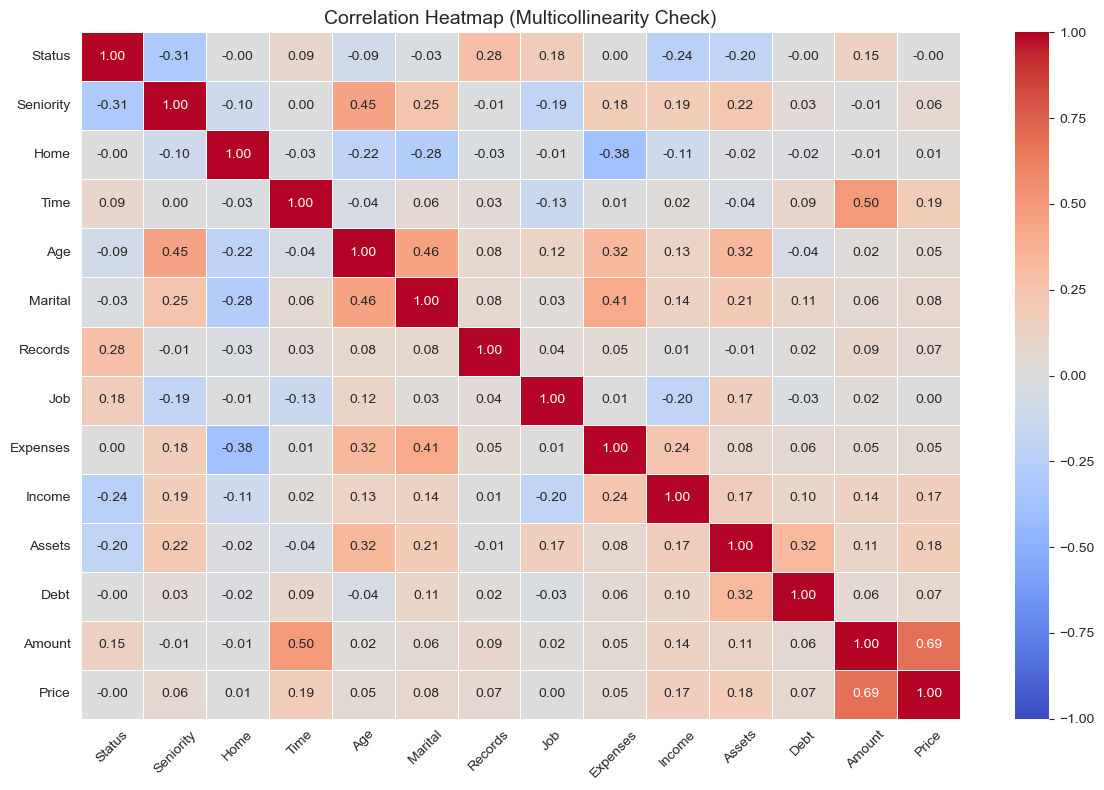

2025-06-18 17:06:34,166 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-18 17:06:34,172 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


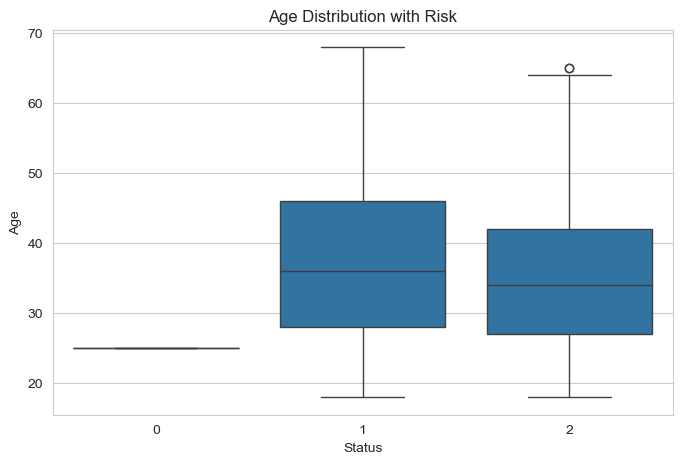

In [85]:
#Distributions of features
category_percentages = Data['Home'].value_counts(normalize=True) * 100
## Display with formatting
print(category_percentages.round(2).astype(str) + '%')
## Spearman correlation (robust to non-linearity)
corr_matrix = Data.corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,      # Show correlation values
    fmt=".2f",       # Format to 2 decimal places
    cmap="coolwarm", # Red (positive) vs. Blue (negative)
    vmin=-1,         # Min correlation value
    vmax=1,          # Max correlation value
    linewidths=0.5,
    cbar=True
)
plt.title("Correlation Heatmap (Multicollinearity Check)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###Boxplot Distribution
fig, ax = plt.subplots(figsize=(8, 5))  # Adjusted figsize for a single plot
sns.boxplot(data=Data, x='Status', y='Age', ax=ax).set_title("Age Distribution with Risk")
plt.show()

In [86]:
#Status — whether the customer managed to pay back the loan (1) or not (2)
#• Seniority — job experience in years
#• Home — the type of homeownership: renting (1), a homeowner (2), and others.
#• Time — period planned for the loan (in months).
#• Age — the age of the client.
#• Marital [status] — single (1), married (2), and others.
#• Records — whether the client has any previous records: no (1), yes (2)2.
#• Job — the type of job: full-time (1), part-time (2), and others.
#• Expenses — how much the client spends per month.
#• Income — how much the client earns per month.
#• Assets — the total worth of all the assets of the client.
#• Debt — the amount of credit debt.
#• Amount — the requested amount of the loan.
#• Price — the price of an item the client wants to buy.


#First, Convert categorical variables from numbers to text to make sense of  status, home, marital, #job are in numbers


## Human readability
'''
def reverse_label_encoding(df):
    status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
    }

    home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
    }

    marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
    }

    records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
    }

    job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
    }

    df.status = df.status.map(status_values)
    df.home = df.home.map(home_values)
    df.marital = df.marital.map(marital_values)
    df.records = df.records.map(records_values)
    df.job = df.job.map(job_values)
'''

"\ndef reverse_label_encoding(df):\n    status_values = {\n    1: 'ok',\n    2: 'default',\n    0: 'unk'\n    }\n\n    home_values = {\n    1: 'rent',\n    2: 'owner',\n    3: 'private',\n    4: 'ignore',\n    5: 'parents',\n    6: 'other',\n    0: 'unk'\n    }\n\n    marital_values = {\n    1: 'single',\n    2: 'married',\n    3: 'widow',\n    4: 'separated',\n    5: 'divorced',\n    0: 'unk'\n    }\n\n    records_values = {\n    1: 'no',\n    2: 'yes',\n    0: 'unk'\n    }\n\n    job_values = {\n    1: 'fixed',\n    2: 'partime',\n    3: 'freelance',\n    4: 'others',\n    0: 'unk'\n    }\n\n    df.status = df.status.map(status_values)\n    df.home = df.home.map(home_values)\n    df.marital = df.marital.map(marital_values)\n    df.records = df.records.map(records_values)\n    df.job = df.job.map(job_values)\n"

In [87]:
# Basic formatting
Data.columns = Data.columns.str.lower()
#Remove unknown, not clear what to do with it
Data = Data[Data.status != 0]
percentages = Data.status.value_counts(normalize=True) * 100
print(percentages.round(2).astype(str) + '%')
Data.head()


status
1    71.85%
2    28.15%
Name: proportion, dtype: object


,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [88]:
## Train Test Split
X = Data.drop(columns=['status'])
y = Data['status']
##Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
logger.info("Dataset shapes:\n"
            "X_train: %s (samples, features)\n"
            "X_test: %s (samples, features)\n"
            "y_train: %s (samples,)\n"
            "y_test: %s (samples,)",
            X_train.shape, X_test.shape, y_train.shape, y_test.shape)

2025-06-18 17:06:34,321 - __main__ - INFO - Dataset shapes:
X_train: (3563, 13) (samples, features)
X_test: (891, 13) (samples, features)
y_train: (3563,) (samples,)
y_test: (891,) (samples,)


2025-06-18 17:06:34,380 - __main__ - INFO - Initialized RandomForestClassifier with parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
2025-06-18 17:06:34,381 - __main__ - INFO - Training RandomForest model on 3563 samples with 13 features...
2025-06-18 17:06:34,636 - __main__ - INFO - Feature Importances:
      Feature  Gini Importance
8      income         0.146923
0   seniority         0.122865
12      price         0.114815
11     amount         0.114664
3         age         0.095371
9      assets         0.078265
7    expenses         0.067767
5     records         0.066351
6         job         0.052645
2      

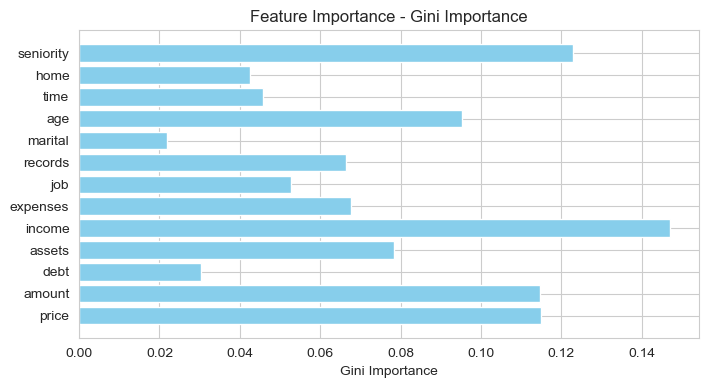

In [89]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
logger.info("Initialized RandomForestClassifier with parameters: %s",
           clf.get_params())
# Train model with logging
logger.info("Training RandomForest model on %d samples with %d features...",
           X_train.shape[0], X_train.shape[1])
clf.fit(X_train, y_train)
importances = clf.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
# Log the feature importance DataFrame in a readable format
logger.info("Feature Importances:\n%s", feature_imp_df.to_string())

# Create a bar plot for feature importance
plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()


In [90]:
'''
def assess_risk(client):
    if client['records'] == 'yes':
      if client['job'] == 'parttime':
          return 'default'
      else:
          return 'ok'
    else:
      if client['assets'] > 6000:
          return 'ok'
      else:
          return 'default'
'''

"\ndef assess_risk(client):\n    if client['records'] == 'yes':\n      if client['job'] == 'parttime':\n          return 'default'\n      else:\n          return 'ok'\n    else:\n      if client['assets'] > 6000:\n          return 'ok'\n      else:\n          return 'default'\n"

In [91]:
# Get the top important feature names from your feature importance DataFrame
#important_features = ['income', 'price', 'seniority', 'amount', 'age']

# Select these features from your original DataFrame X
#X_important = X[important_features]

# Log the operation with details
#logger.info("Selected top %d important features: %s",
       #    len(important_features),
       #    ", ".join(important_features))
#logger.debug("Shape of reduced feature set: %s", X_important.shape)
#logger.debug("First 5 rows of selected features:\n%s",
    #        X_important.head().to_string())
#

In [109]:
logger.info("Performing train-test split on important features...")
X_train_imp, X_test_imp, y_train, y_test = train_test_split(
    X,  # Your reduced feature set
    y,            # Target variable
    test_size=0.2,  # Adjust as needed
    random_state=42,  # For reproducibility
    stratify=y     # If classification problem
)
# Log the results
logger.info("Train-test split completed with parameters: test_size=0.2, random_state=42")
logger.info("X_train_imp shape: %s (%.1f%% of data)",
           X_train_imp.shape,
           (X_train_imp.shape[0]/len(X_important))*100)
logger.info("X_test_imp shape: %s (%.1f%% of data)",
           X_test_imp.shape,
           (X_test_imp.shape[0]/len(X_important))*100)
logger.info("y_train distribution:\n%s",
           pd.Series(y_train).value_counts(normalize=True).to_string())
logger.info("y_test distribution:\n%s",
           pd.Series(y_test).value_counts(normalize=True).to_string())

2025-06-18 17:23:53,085 - __main__ - INFO - Performing train-test split on important features...
2025-06-18 17:23:53,094 - __main__ - INFO - Train-test split completed with parameters: test_size=0.2, random_state=42
2025-06-18 17:23:53,095 - __main__ - INFO - X_train_imp shape: (3563, 13) (80.0% of data)
2025-06-18 17:23:53,095 - __main__ - INFO - X_test_imp shape: (891, 13) (20.0% of data)
2025-06-18 17:23:53,097 - __main__ - INFO - y_train distribution:
status
1    0.718496
2    0.281504
2025-06-18 17:23:53,098 - __main__ - INFO - y_test distribution:
status
1    0.718294
2    0.281706


In [119]:
dict_train = X_train_imp.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
print(f"Dimensionality after OHE: {X_train.shape[-1]}")
dict_val = X_test_imp.to_dict(orient='records')
X_val = dv.transform(dict_val)

Dimensionality after OHE: 13


In [120]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(auc)

print('train auc', auc)
y_pred = lr.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('validation auc', auc)
#X_val = dv.transform(dict_val)

0.6705354639207377
train auc 0.6705354639207377
validation auc 0.6186628486055777


/opt/anaconda3/envs/ml_credit_scoring/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [121]:
from sklearn.tree import DecisionTreeClassifier
from time import time

# Configure logging (save to a file & print to console)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('decision_tree_training.log'),
        logging.StreamHandler()
    ]
)

# Initialize and train the Decision Tree
dt = DecisionTreeClassifier(max_depth=2)
logging.info("Training Decision Tree...")

start_time = time()  # Track training time
dt.fit(X_train, y_train)
training_time = time() - start_time

# Log key details
logging.info(f"Training completed in {training_time:.2f} seconds")
logging.info(f"Decision Tree parameters: {dt.get_params()}")
logging.info(f"Max tree depth: {dt.tree_.max_depth}")
logging.info(f"Number of leaves: {dt.tree_.n_leaves}")

2025-06-18 17:39:06,635 - root - INFO - Training Decision Tree...
2025-06-18 17:39:06,640 - root - INFO - Training completed in 0.00 seconds
2025-06-18 17:39:06,641 - root - INFO - Decision Tree parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
2025-06-18 17:39:06,641 - root - INFO - Max tree depth: 2
2025-06-18 17:39:06,642 - root - INFO - Number of leaves: 4


In [122]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(auc)

0.7163232957377867


In [107]:
y_pred = dt.predict_proba(X_test_imp)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.7064056274900399)

In [123]:
print('train auc', auc)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('validation auc', auc)

train auc 0.7163232957377867
validation auc 0.7274028884462151


In [80]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("LoanApproval-DT")
with mlflow.start_run(run_name="LoanApproval-DecisionTrees"):
    mlflow.log_param("auc", auc)
    with open("dict_vectorizer.bin", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("dict_vectorizer.bin")

    mlflow.sklearn.log_model(dt, artifact_path="model")

2025/06/18 15:46:28 INFO mlflow.tracking.fluent: Experiment with name 'LoanApproval-DT' does not exist. Creating a new experiment.
2025/06/18 15:46:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LoanApproval-DecisionTrees at: http://localhost:5000/#/experiments/368147529244728101/runs/2a8ce022bd5048a9909c0c35b9d9b63c
🧪 View experiment at: http://localhost:5000/#/experiments/368147529244728101
